In [1]:
import numpy as np
import matplotlib.pyplot as plt
# alpha = latency, units are in s
# beta = 1/bandwidth, units of bandwiths is in GB/s
# P = number of processors in the entire system, units are in numbers :)
# N = message size, units are in GB
# gamma = number of processors in a group in Tencent's AllReduce


In [2]:
LT = 10e-5 #in seconds
BW = 26843545600 #25GB/s, in bytes/second

In [3]:
""" def Torus2D_Tencent(latency, bandwidth, P, N, gamma):
    alpha = latency
    beta = 1/bandwidth
    val = 4*(gamma-1)*(alpha+beta*N/gamma) + 2*(P/gamma-1)*(alpha+beta*N*gamma/P)
    return val if val>0 else 0 """

def Torus2D_Google(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 4*alpha*(np.sqrt(P)-1) + 4*beta*N*(np.sqrt(P)-1)/np.sqrt(P)

def Dragonfly_Hierarchical_dimensionPipelined(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    p_hat = np.sqrt(np.sqrt(1+4*P)-1)/2
    return alpha*(2*np.log2(p_hat)+5*p_hat-3) + beta*N + 2*np.sqrt(alpha*beta*N*(2*np.log2(p_hat)+5*p_hat-3))

def Dragonfly_Hierarchical_dimensionNotPipelined(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    p_hat = np.sqrt(np.sqrt(1+4*P)-1)/2

    R_stage = alpha*(np.log(p_hat)-1) + beta*N + 2*np.sqrt(max((np.log(p_hat)-1)*beta*N*alpha,0))
    L_stage = alpha*(2*p_hat-1) + beta*(2*p_hat-1)*N
    G_stage = p_hat*alpha + p_hat*beta*N

    return R_stage+L_stage+G_stage+L_stage+R_stage

def Ring(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 2*(P-1)*alpha + 2*beta*N*(P-1)/P

def Tree(latency, bandwidth, P, N): 
    alpha = latency
    beta = 1/bandwidth
    return 2*alpha*(np.log2(P)-1) + 2*beta*N + 4*np.sqrt((np.log2(P)-1)*beta*N*alpha)

def DoubleTree(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return alpha*(2*np.log(P)-1) + beta*N + np.sqrt(4*beta*N*alpha*(2*np.log(P)-1))

def Rabenseifner(latency, bandwidth, P, N):
    alpha = latency
    beta = 1/bandwidth
    return 


In [4]:
def sweepProcessors(algos, N=20*2**20, P_low=4, P_high=1024, P_step=1):
    results = {}
    x_axis = list(range(P_low, P_high+1, P_step))


    for p in x_axis:
        for key in algos:
            if key not in results.keys():
                results[key]=[algos[key](LT, BW, p, N)]
            else:
                results[key].append(algos[key](LT, BW, p, N))
    return results, x_axis, ["Sweeping Number of Processors", "Num of Processors", "Communication cost (s)"]

def sweepMessageSize(algos, P=256, N_low = 2**20, N_high=200*2**20, N_step=2**20):
    results = {}
    x_axis = list(range(N_low, N_high+1, N_step))

    for n in x_axis:
        for key in algos:
            if key not in results.keys():
                results[key]=[algos[key](LT, BW, P, n)]
            else:
                results[key].append(algos[key](LT, BW, P, n))
                
    return results, x_axis, ["Sweeping message size", "Message size", "Communication cost(s)"]


In [5]:
def plotData(results, x_axis, PlotInfo):
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(111)

    plt.tight_layout()
    plt.title(PlotInfo[0], fontsize=20)
    plt.xlabel(PlotInfo[1], fontsize=20)
    plt.ylabel(PlotInfo[2], fontsize=20)

    for key in results:
        ax.plot(x_axis, results[key], label=key)
    
    plt.legend()
    plt.show()

### some experiments
N = 20MB 

P is swept from 4 to 1024 

latency is 10 microseconds, bandwidth is 25GB/s 


In [31]:
algos = { 
        "Dragonfly Hierarchical AR, dimension pipelining": Dragonfly_Hierarchical_dimensionPipelined,
        "Dragonfly Hierearchical AR, no dimension pipelining": Dragonfly_Hierarchical_dimensionNotPipelined,
        # "Torus2D AR":Torus2D_Google,
        # "Ring AR": Ring,
        } 

In [38]:
results, x_axis, plotInfo = sweepProcessors(algos, N=20*2**20, P_low=4, P_high=100000)

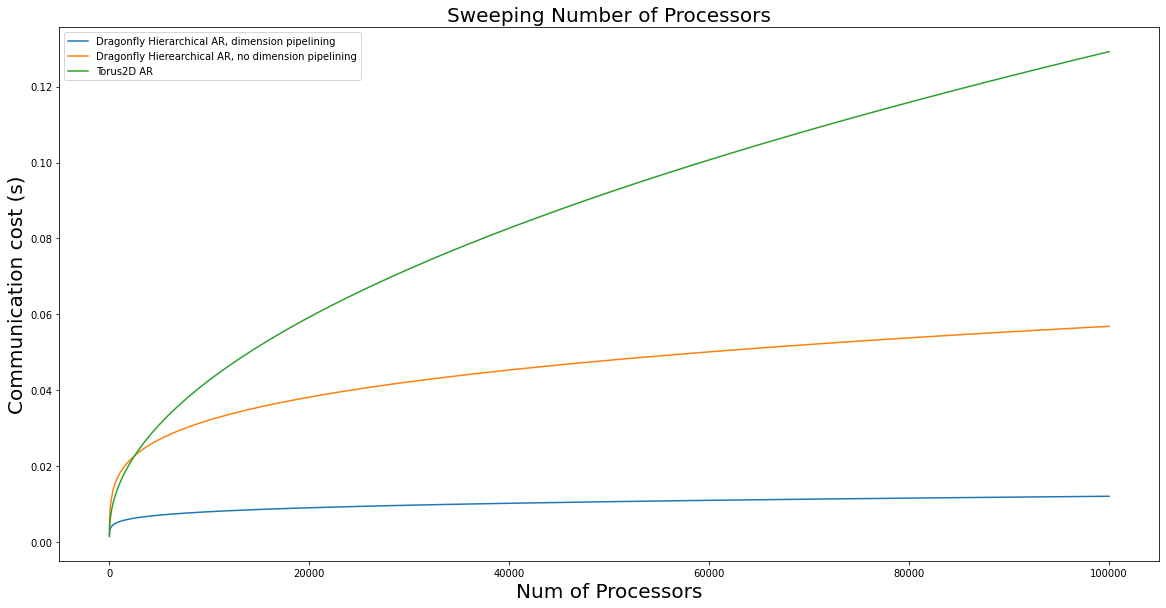

In [39]:
plotData(results, x_axis, plotInfo)

In [388]:
results, x_axis, plotInfo = sweepMessageSize(algos, P=80000, N_low=20*2**20, N_high = 20*2**30)

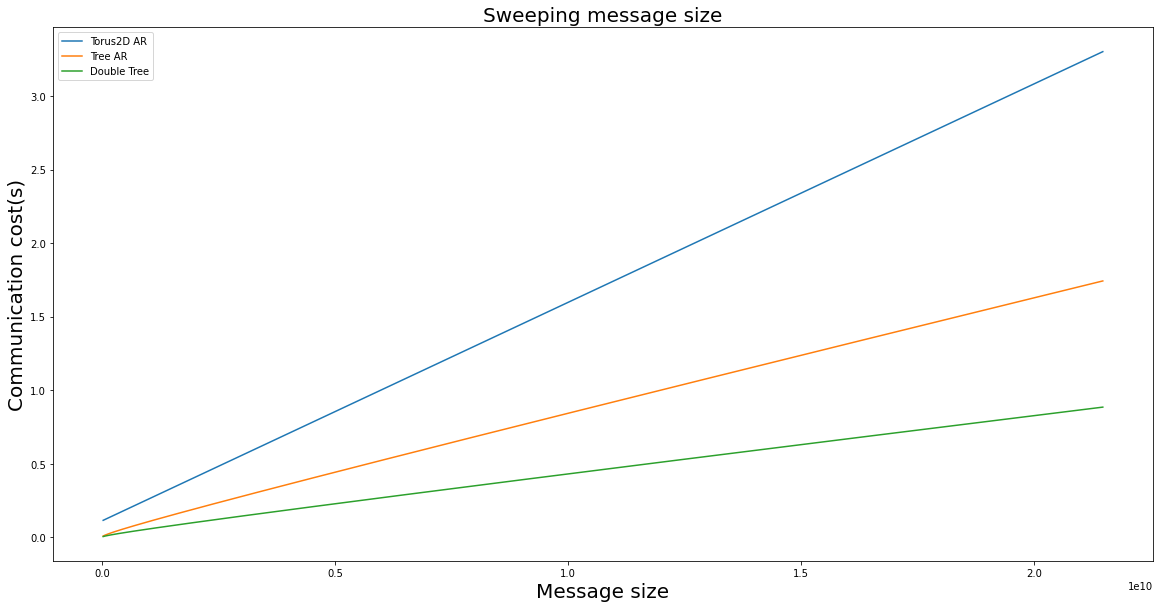

In [389]:
plotData(results, x_axis, plotInfo)

In [246]:
4*5**4 + 2*5**2

2550